# Customer Segmentation using K-Means clustering algorithm

![](http://spoosh.me/blog/wp-content/uploads/2019/10/vectorstock_25537972-e1570695999619.png)

In [1]:
#Load required libraries.
library(tidyverse)
library(lattice)
library(cowplot)
library(reshape2)
library(ggplot2)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.3.6      ✔ purrr   0.3.5 
✔ tibble  3.1.8      ✔ dplyr   1.0.10
✔ tidyr   1.2.1      ✔ stringr 1.4.1 
✔ readr   2.1.3      ✔ forcats 0.5.2 
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Attaching package: ‘reshape2’


The following object is masked from ‘package:tidyr’:

    smiths




In [2]:
#Import the dataset.
data<-read_csv('../input/123qweasd/Mall_Customers.csv')

Rows: 200 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (1): Gender
dbl (4): CustomerID, Age, Annual Income (k$), Spending Score (1-100)

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [3]:
#Read the first lines of the dataset.
head(data)

CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
<dbl>,<chr>,<dbl>,<dbl>,<dbl>
1,Male,19,15,39
2,Male,21,15,81
3,Female,20,16,6
4,Female,23,16,77
5,Female,31,17,40
6,Female,22,17,76


In [4]:
#Remove any missing data.
data<-na.omit(data)

#Rename certain columns for easier manipulation.
data<-data %>% rename(
    Annual_Income='Annual Income (k$)',
    Spending_Score='Spending Score (1-100)')

In [5]:
#Customer ID (unique identifier of each customer) isn’t useful for our analysis, so the column can be excluded from the dataframe.
customer<-data[,2:5]

# **Exploratory Data Analysis**

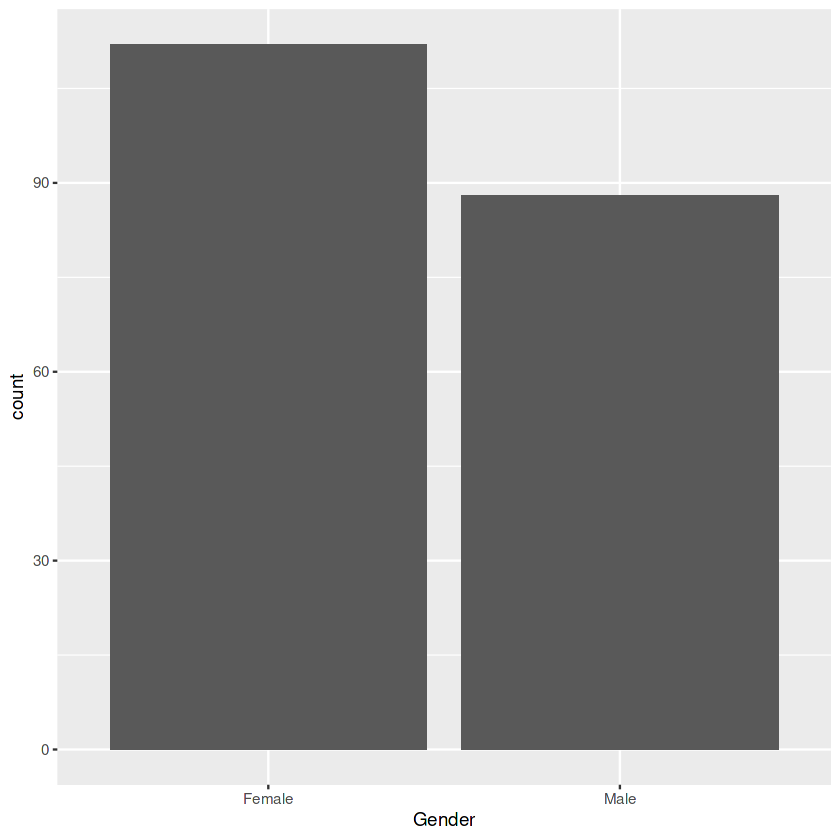

In [6]:
#Gender bar graph.
ggplot(customer, aes(x = Gender)) + geom_bar()

#### **The number of female customers surpass that of the male customers.**

In [7]:
prop.table(table(customer$Gender)) 


Female   Male 
  0.56   0.44 

#### **In fact, 56% of the customers are females, while 44% are males.**

In [8]:
#Gender is a categorical variable that has to be converted into numerical for our clustering analysis.
cdataset<-customer %>% mutate(dummy=1) %>% spread(key=Gender,value=dummy, fill=0)

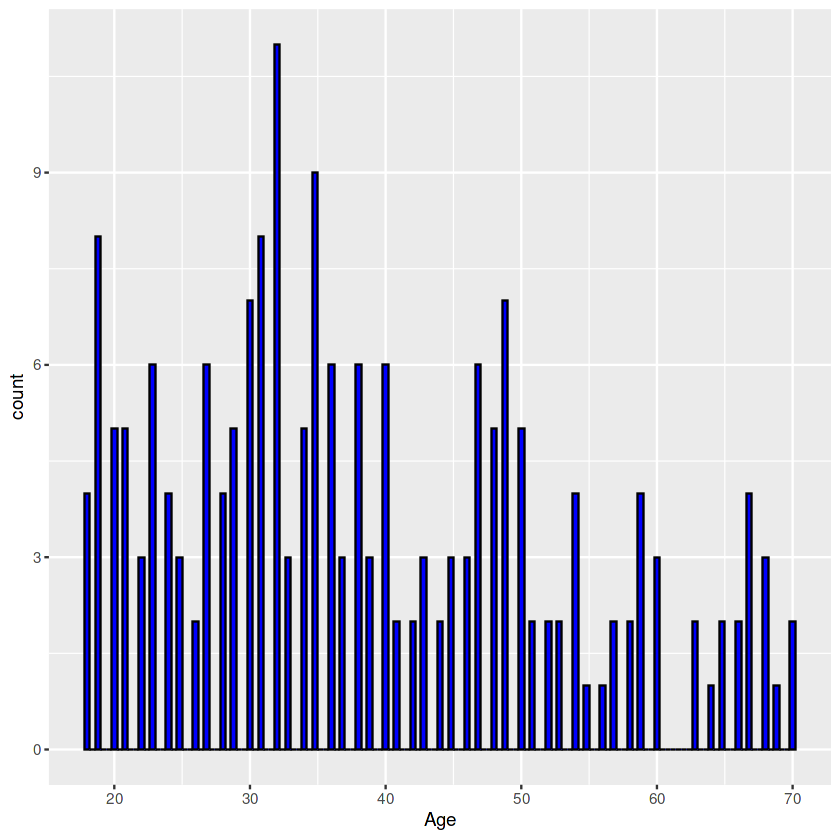

In [9]:
#Plot customers' age variance: useful for targeted demographics.
ggplot(cdataset, aes(x=Age)) + geom_histogram(binwidth=.40,colour='black', fill='blue')

#### **Most of the customers are in their mid 30s, followed by customers in their mid 20s.**

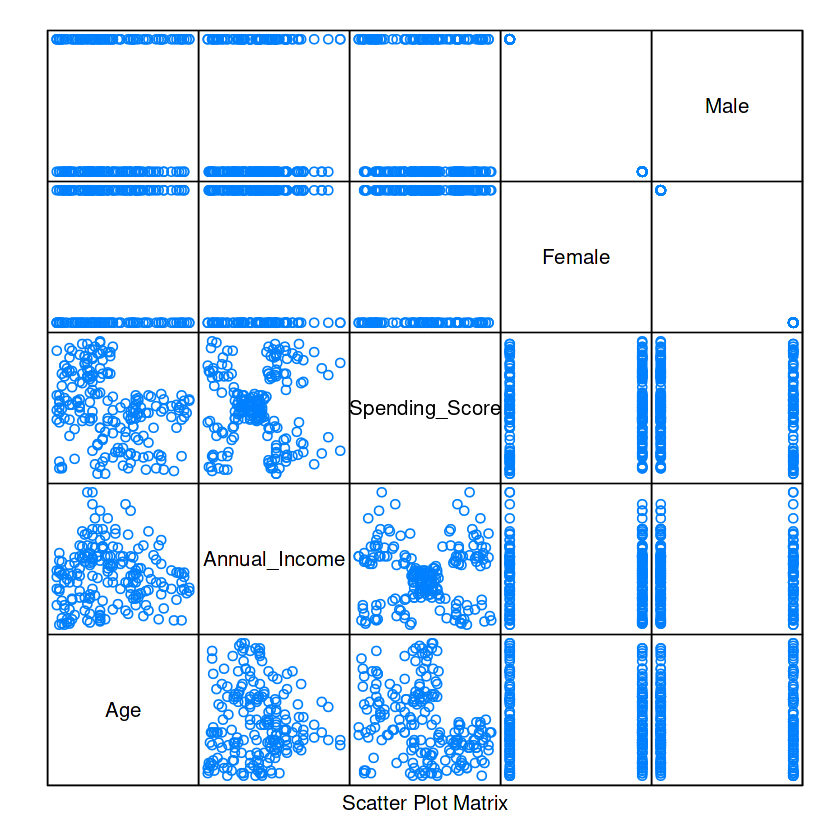

In [10]:
#Pair-wise relationships of the variables: scatter plot matrix.
splom(~cdataset, groups=NULL,data=cdataset,axis.line.tck=0,axis.text.alpha=0)

#### **Let's take a closer look to the above-shown relationships by creating separate scatterplots for all the different pairs of variables.**

In [11]:
p1<-ggplot(cdataset, aes(x=Age, y=Annual_Income)) + geom_point(color='red') + ggtitle('Age and Annual Income') + xlab('Age') + ylab('Annual Income')
p2<-ggplot(cdataset, aes(x=Age, y=Spending_Score)) + geom_point(color='blue') + ggtitle('Age and Spending Score') + xlab('Age') + ylab('Spending Score')
p3<-ggplot(cdataset, aes(x=Annual_Income, y=Spending_Score)) + geom_point(color='green') + ggtitle('Annual Income and Spending Score') + xlab('Annual Income') + ylab('Spending Score')
p4<-ggplot(cdataset, aes(x=(Female==1), y=Annual_Income)) + geom_point(color='orange') + ggtitle('Gender and Annual Income') + xlab('Gender') + ylab('Annual Income')
p5<-ggplot(cdataset, aes(x=(Female==1), y=Spending_Score)) + geom_point(color='purple') + ggtitle('Gender and Spending Score') + xlab('Gender') + ylab('Spending Score')
p6<-ggplot(cdataset, aes(x=(Female==1), y=Age)) + geom_point(color='pink') + ggtitle('Gender and Age') + xlab('Gender') + ylab('Age')
#plot_grid(p1,p2,p3,p4,p5,p6) remove # to run the code

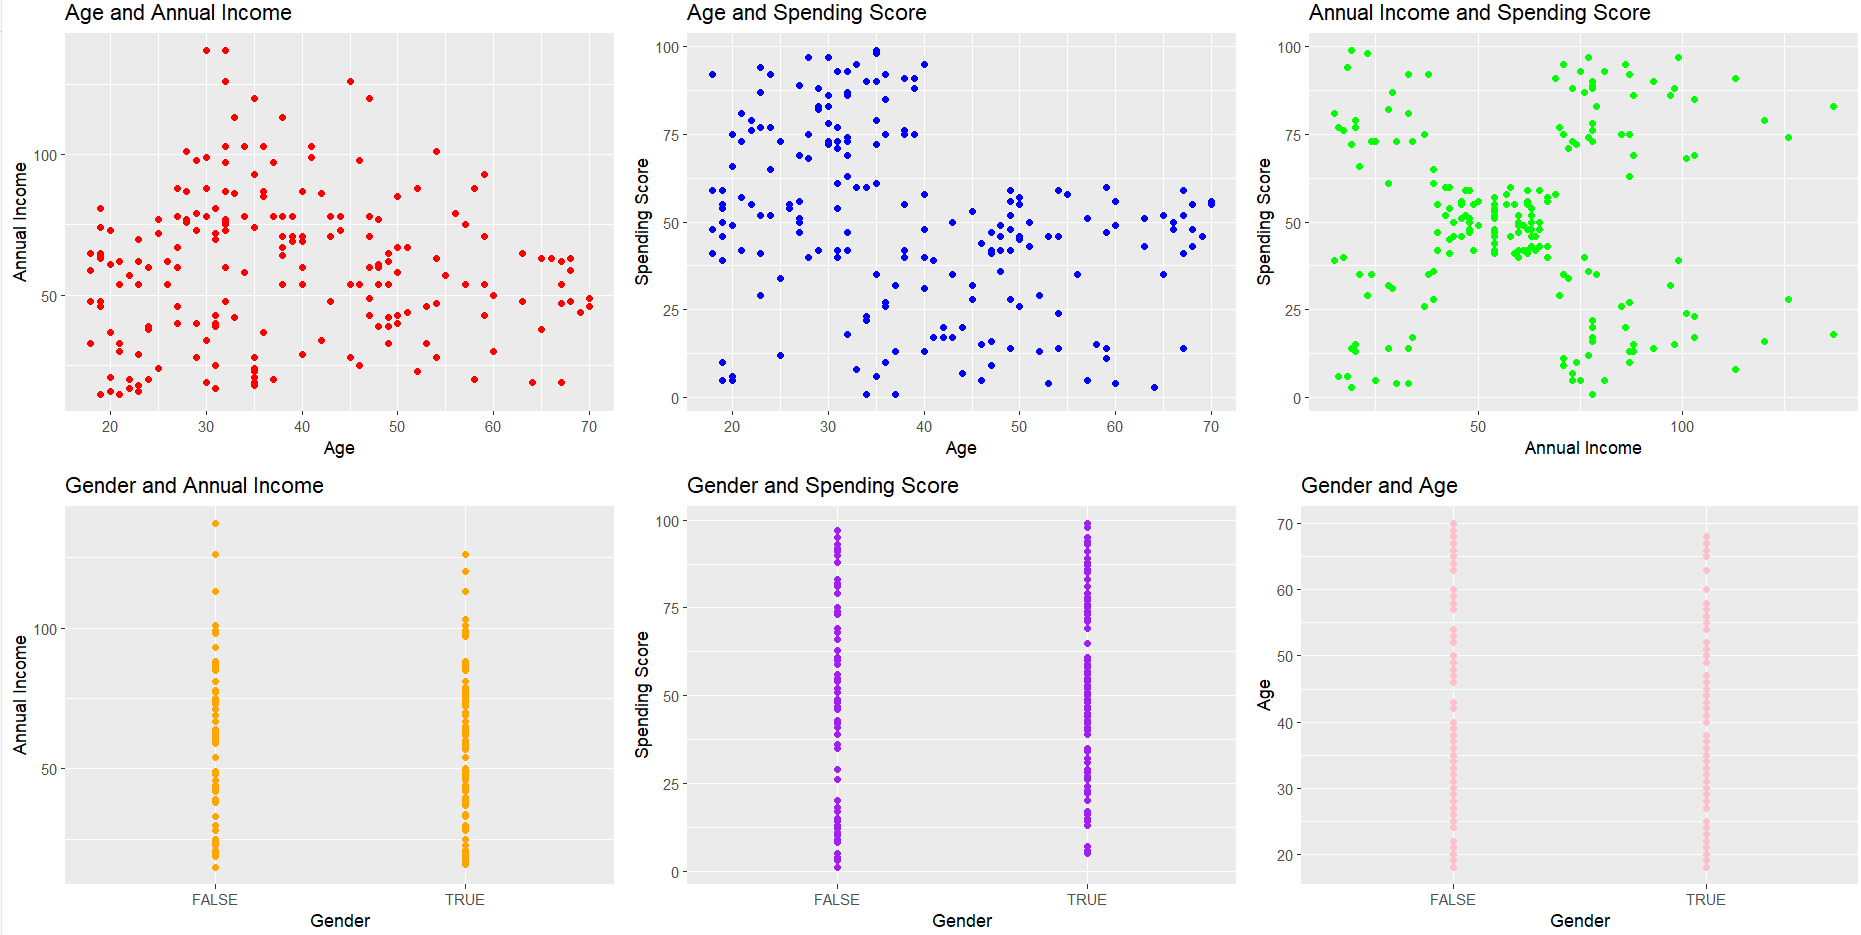

#### **Insights:**
#### 1. The highest annual income is for those between ages 30 and 50.
#### 2. The lower the age, the higher the spending score.
#### 3. No linear relationship for annual income & spending score. Looks like a formation of five different groups of customers.
#### 4. Male customers seem to have higher income compared to females.
#### 5. Female customers have a slightly higher spending score compared to males.
#### 6. Males seem to be slightly older than females.

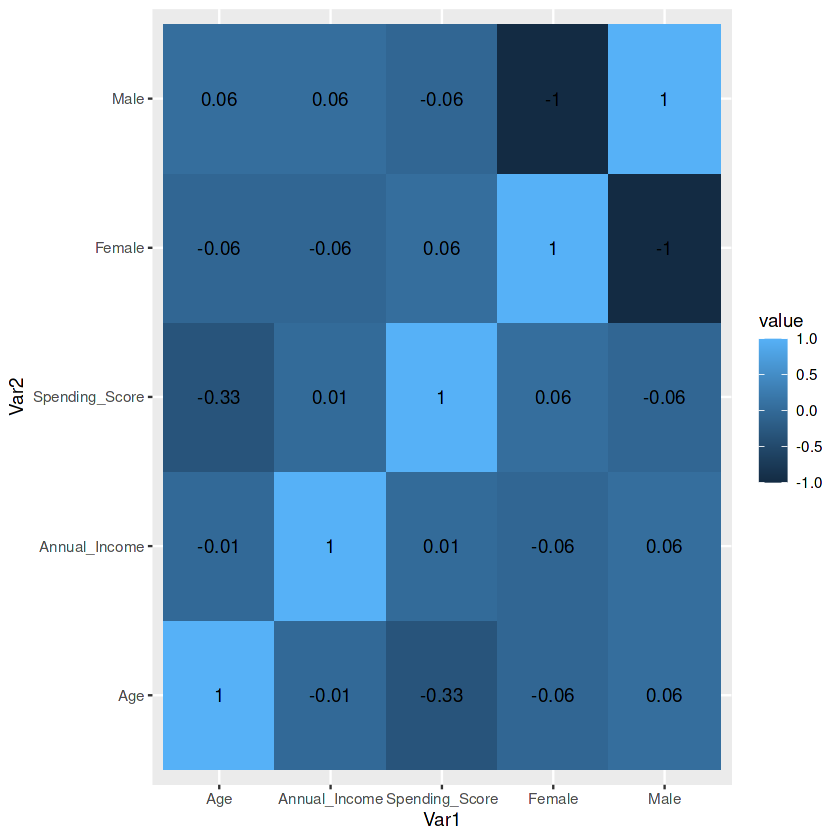

In [12]:
#Plot a Correlation Matrix to look into multivariate relationships.
cmatrix<-as.matrix(cdataset)
cormat <- round(cor(cmatrix),2)
melted_corr_mat <- melt(cormat)
ggplot(data = melted_corr_mat, aes(x=Var1, y=Var2, fill=value)) + geom_tile() + geom_text(aes(Var2, Var1, label = value))

#### **Insights:**
#### 1. We will ignore the misleading perfect negative relationship of the dummy variables 'male' and 'female'.
#### 2. Age has a significant negative relationship with Spending Score.

In [13]:
#Feature Scaling of all variables (exclude 'male' and 'female' dummy variables).
scaled_data<-scale(cdataset[,1:3])

# **Model Building**

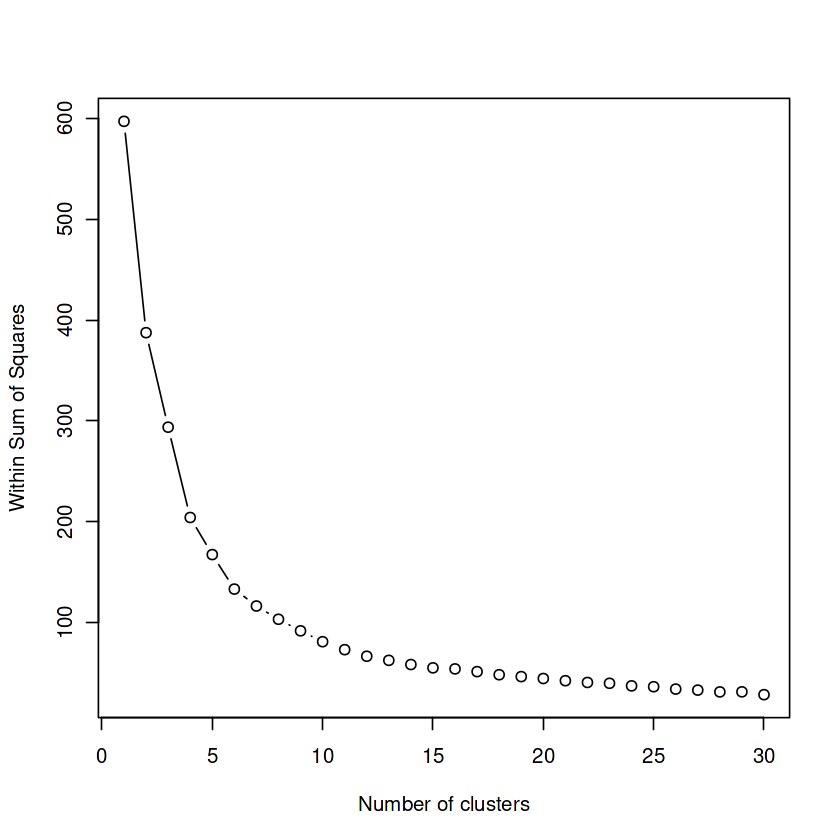

In [14]:
#Find the k value.
wss <- numeric(30)
for(k in 1:30){
  wss[k]<-sum(kmeans(scaled_data, centers=k, nstart = 25, iter.max = 50)$withinss)
}


#Plot the Within Sum of Squares
plot(1:30,wss,type='b',xlab='Number of clusters',ylab='Within Sum of Squares')

#### The WSS starts to reduce sharply when k increases with a substantial reduction at k=5. The improvement in WSS is fairly linear for k>5. Therefore, the k-means analysis will be conducted for k=5.

In [15]:
# Fitting K-Means to the dataset.
set.seed(123)
km<-kmeans(customer[,3:4],5,nstart=25)
customer$ClusterNumber<-km$cluster

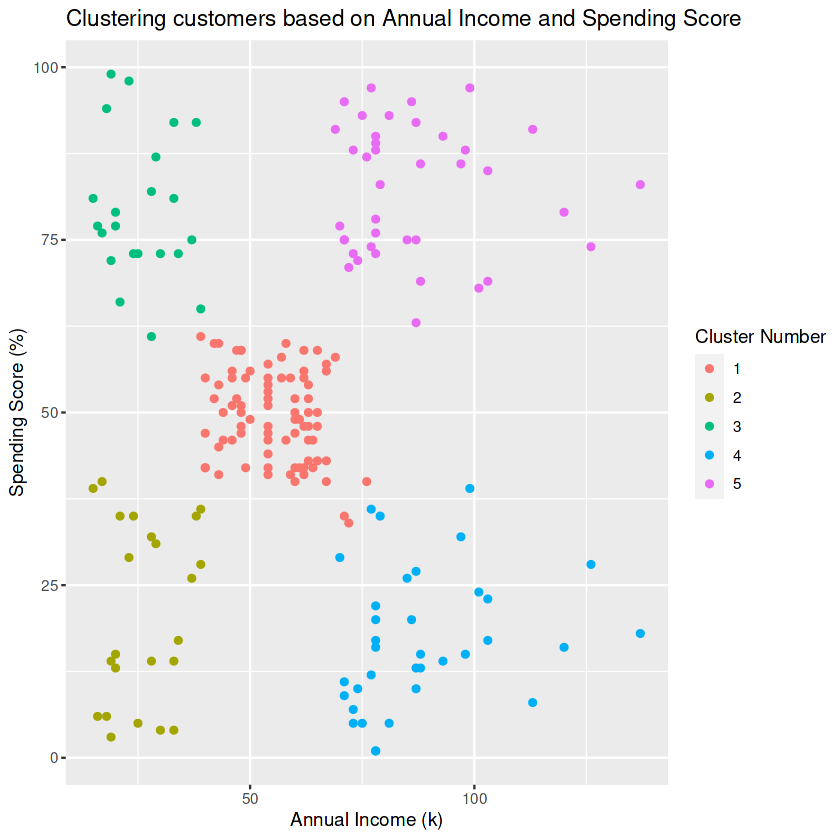

In [16]:
# Visualizing the clusters.
ggplot(customer[,3:5]) + geom_point(aes(x = Annual_Income, y = Spending_Score, col = as.factor(ClusterNumber))) + scale_color_discrete(name="Cluster Number") + ggtitle('Clustering customers based on Annual Income and Spending Score') + xlab('Annual Income (k)') + ylab('Spending Score (%)')

#### Our data can be divided into **5 clusters**:
#### Cluster #1 (*Purple*) - **High annual income and high spending score**.
#### Cluster #2 (*Green*) - **Low annual income and high spending score**.
#### Cluster #3 (*Blue*) - **High annual income and low spending score**.
#### Cluster #4 (*Red*) - **Average annual income and average spending score**.
#### Cluster #5 (*Olive*) - **Low annual income and low spending score**.

#### Let's get a closer look into the attributes of these 5 clusters and compare them. 

In [17]:
avg_num<-customer %>% group_by(ClusterNumber) %>% summarise_at(vars(Age,Annual_Income,Spending_Score), mean)
avg_num

ClusterNumber,Age,Annual_Income,Spending_Score
<int>,<dbl>,<dbl>,<dbl>
1,42.71605,55.29630,49.51852
2,45.21739,26.30435,20.91304
3,25.27273,25.72727,79.36364
4,41.11429,88.20000,17.11429
5,32.69231,86.53846,82.12821


In [18]:
avg_gen<-table(customer$Gender,customer$ClusterNumber)
avg_gen

        
          1  2  3  4  5
  Female 48 14 13 16 21
  Male   33  9  9 19 18

# **Cluster Analysis**

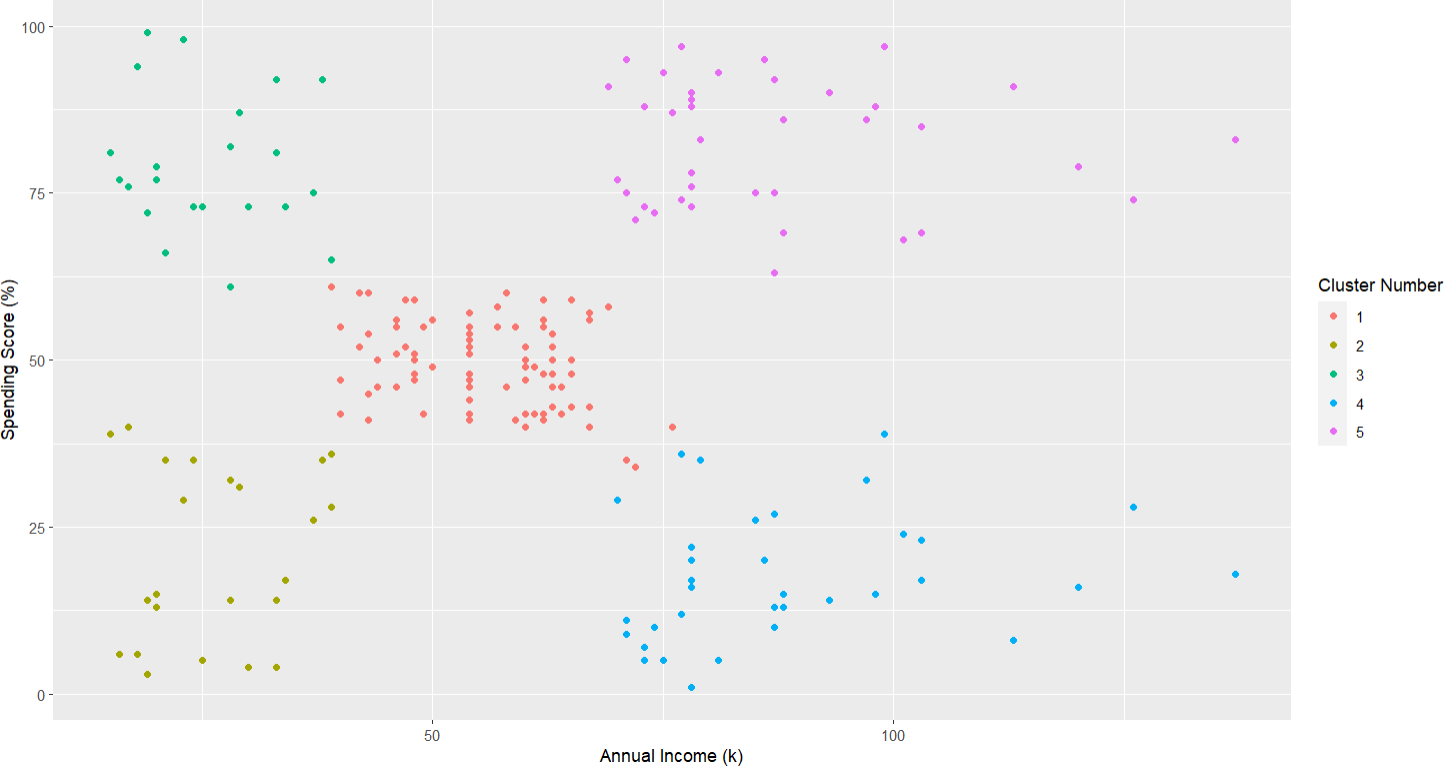

#### Cluster #1 (*Red*) - **Average annual income and average spending score**.
##### - Average Age: early 40s.
##### - Average Annual income: 55k.
##### - Average Spending score: 50%.
##### - Gender: mostly female customers (59%).

#### Cluster #5 (*Olive*) - **Low annual income and low spending score**.
##### - Average Age: mid 40s.
##### - Average Annual income: 26k.
##### - Average Spending score: 21%.
##### - Gender: mostly female customers (61%).

#### Cluster #3 (*Green*) - **Low annual income and high spending score**.
##### - Average Age: mid 20s.
##### - Average Annual income: 26k.
##### - Average Spending score: 79%.
##### - Gender: mostly female customers (59%).

#### Cluster #4 (*Blue*) - **High annual income and low spending score**.
##### - Average Age: early 40s.
##### - Annual income: 88k.
##### - Spending score: 17%.
##### - Gender: slightly more male customers (54%).

#### Cluster #5 (*Purple*) - **High annual income and high spending score**.
##### - Age: early 30s.
##### - Average Annual income: 87k.
##### - Average Spending score: 82%.
##### - Gender: slightly more female customers (54%).